#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # 稀疏数据和嵌入简介

**学习目标：**
* 将影评字符串数据转换为稀疏特征矢量
* 使用稀疏特征矢量实现情感分析线性模型
* 通过将数据投射到二维空间的嵌入来实现情感分析 DNN 模型
* 将嵌入可视化，以便查看模型学到的词语之间的关系

在此练习中，我们将探讨稀疏数据，并使用影评文本数据（来自 [ACL 2011 IMDB 数据集](http://ai.stanford.edu/~amaas/data/sentiment/)）进行嵌入。这些数据已被处理成 `tf.Example` 格式。

 ## 设置

我们导入依赖项并下载训练数据和测试数据。[`tf.keras`](https://www.tensorflow.org/api_docs/python/tf/keras) 中包含一个文件下载和缓存工具，我们可以用它来检索数据集。

In [1]:
from __future__ import print_function

import collections
import io
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython import display
from sklearn import metrics

tf.logging.set_verbosity(tf.logging.ERROR)
train_url = 'https://download.mlcc.google.cn/mledu-datasets/sparse-data-embedding/train.tfrecord'
train_path = tf.keras.utils.get_file(train_url.split('/')[-1], train_url)
test_url = 'https://download.mlcc.google.cn/mledu-datasets/sparse-data-embedding/test.tfrecord'
test_path = tf.keras.utils.get_file(test_url.split('/')[-1], test_url)

40697856/40688441 [==============================] - 0s 0us/step


 ## 构建情感分析模型

 我们根据这些数据训练一个情感分析模型，以预测某条评价总体上是*好评*（标签为 1）还是*差评*（标签为 0）。

为此，我们会使用*词汇表*（即我们预计将在数据中看到的每个术语的列表），将字符串值 `terms` 转换为特征矢量。在本练习中，我们创建了侧重于一组有限术语的小型词汇表。其中的大多数术语明确表示是*好评*或*差评*，但有些只是因为有趣而被添加进来。

词汇表中的每个术语都与特征矢量中的一个坐标相对应。为了将样本的字符串值 `terms` 转换为这种矢量格式，我们按以下方式处理字符串值：如果该术语没有出现在样本字符串中，则坐标值将为 0；如果出现在样本字符串中，则值为 1。未出现在该词汇表中的样本中的术语将被弃用。

 **注意**：*我们当然可以使用更大的词汇表，而且有创建此类词汇表的专用工具。此外，我们可以添加少量的 OOV（未收录词汇）分桶，您可以在其中对词汇表中未包含的术语进行哈希处理，而不仅仅是弃用这些术语。我们还可以使用__特征哈希__法对每个术语进行哈希处理，而不是创建显式词汇表。这在实践中很有效，但却不具备可解读性（这对本练习非常实用）。如需了解处理此类词汇表的工具，请参阅 tf.feature_column 模块。*

 ## 构建输入管道

 首先，我们来配置输入管道，以将数据导入 TensorFlow 模型中。我们可以使用以下函数来解析训练数据和测试数据（格式为 [TFRecord](https://www.tensorflow.org/guide/datasets#consuming_tfrecord_data)），然后返回一个由特征和相应标签组成的字典。

In [0]:
def _parse_function(record):
  """Extracts features and labels.
  
  Args:
    record: File path to a TFRecord file    
  Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A tensor with the corresponding labels.
  """
  features = {
    "terms": tf.VarLenFeature(dtype=tf.string), # terms are strings of varying lengths
    "labels": tf.FixedLenFeature(shape=[1], dtype=tf.float32) # labels are 0 or 1
  }
  
  parsed_features = tf.parse_single_example(record, features)
  
  terms = parsed_features['terms'].values
  labels = parsed_features['labels']

  return  {'terms':terms}, labels

 为了确认函数是否能正常运行，我们为训练数据构建一个 `TFRecordDataset`，并使用上述函数将数据映射到特征和标签。

In [3]:
# Create the Dataset object.
ds = tf.data.TFRecordDataset(train_path)
# Map features and labels with the parse function.
ds = ds.map(_parse_function)

ds

<DatasetV1Adapter shapes: ({terms: (?,)}, (1,)), types: ({terms: tf.string}, tf.float32)>

 运行以下单元，以从训练数据集中获取第一个样本。

In [4]:
n = ds.make_one_shot_iterator().get_next()
sess = tf.Session()
sess.run(n)

({'terms': array(['but', 'it', 'does', 'have', 'some', 'good', 'action', 'and', 'a',
         'plot', 'that', 'is', 'somewhat', 'interesting', '.', 'nevsky',
         'acts', 'like', 'a', 'body', 'builder', 'and', 'he', 'isn', "'",
         't', 'all', 'that', 'attractive', ',', 'in', 'fact', ',', 'imo',
         ',', 'he', 'is', 'ugly', '.', '(', 'his', 'acting', 'skills',
         'lack', 'everything', '!', ')', 'sascha', 'is', 'played', 'very',
         'well', 'by', 'joanna', 'pacula', ',', 'but', 'she', 'needed',
         'more', 'lines', 'than', 'she', 'was', 'given', ',', 'her',
         'character', 'needed', 'to', 'be', 'developed', '.', 'there',
         'are', 'way', 'too', 'many', 'men', 'in', 'this', 'story', ',',
         'there', 'is', 'zero', 'romance', ',', 'too', 'much', 'action',
         ',', 'and', 'way', 'too', 'dumb', 'of', 'an', 'ending', '.', 'it',
         'is', 'very', 'violent', '.', 'i', 'did', 'however', 'love', 'the',
         'scenery', ',', 'this', 'mov

 现在，我们构建一个正式的输入函数，可以将其传递给 TensorFlow Estimator 对象的 `train()` 方法。

In [0]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
def _input_fn(input_filenames, num_epochs=None, shuffle=True):
  
  # Same code as above; create a dataset and map features and labels.
  ds = tf.data.TFRecordDataset(input_filenames)
  ds = ds.map(_parse_function)

  if shuffle:
    ds = ds.shuffle(10000)

  # Our feature data is variable-length, so we pad and batch
  # each field of the dataset structure to whatever size is necessary.     
  ds = ds.padded_batch(25, ds.output_shapes)
  
  ds = ds.repeat(num_epochs)

  
  # Return the next batch of data.
  features, labels = ds.make_one_shot_iterator().get_next()
  return features, labels

 ## 任务 1：使用具有稀疏输入和显式词汇表的线性模型

对于我们的第一个模型，我们将使用 50 个信息性术语来构建 [`LinearClassifier`](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearClassifier) 模型；始终从简单入手！

以下代码将为我们的术语构建特征列。[`categorical_column_with_vocabulary_list`](https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_vocabulary_list) 函数可使用“字符串-特征矢量”映射来创建特征列。

In [0]:
# 50 informative terms that compose our model vocabulary. 
informative_terms = ("bad", "great", "best", "worst", "fun", "beautiful",
                     "excellent", "poor", "boring", "awful", "terrible",
                     "definitely", "perfect", "liked", "worse", "waste",
                     "entertaining", "loved", "unfortunately", "amazing",
                     "enjoyed", "favorite", "horrible", "brilliant", "highly",
                     "simple", "annoying", "today", "hilarious", "enjoyable",
                     "dull", "fantastic", "poorly", "fails", "disappointing",
                     "disappointment", "not", "him", "her", "good", "time",
                     "?", ".", "!", "movie", "film", "action", "comedy",
                     "drama", "family")

terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key="terms", vocabulary_list=informative_terms)

 接下来，我们将构建 `LinearClassifier`，在训练集中训练该模型，并在评估集中对其进行评估。阅读上述代码后，运行该模型以了解其效果。

In [7]:
my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

feature_columns = [ terms_feature_column ]


classifier = tf.estimator.LinearClassifier(
  feature_columns=feature_columns,
  optimizer=my_optimizer,
)

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Training set metrics:
loss 11.401773
accuracy_baseline 0.5
global_step 1000
recall 0.88152
auc 0.8709892
prediction/mean 0.5369088
precision 0.74027544
label/mean 0.5
average_loss 0.45607093
auc_precision_recall 0.8604641
accuracy 0.78612
---
Test set metrics:
loss 11.419296
accuracy_baseline 0.5
global_step 1000
recall 0.87576
auc 0.8690995
prediction/mean 0.5349597
precision 0.7384148
label/mean 0.5
average_loss 0.45677185
auc_precision_recall 0.8574375
accuracy 0.78276
---


 ## 任务 2：使用深度神经网络 (DNN) 模型

上述模型是一个线性模型，效果非常好。但是，我们可以使用 DNN 模型实现更好的效果吗？

我们将 `LinearClassifier` 切换为 [`DNNClassifier`](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier)。运行以下单元，看看您的模型效果如何。

In [8]:
##################### Here's what we changed ##################################
classifier = tf.estimator.DNNClassifier(                                      #
  feature_columns=[tf.feature_column.indicator_column(terms_feature_column)], #
  hidden_units=[20,20],                                                       #
  optimizer=my_optimizer,                                                     #
)                                                                             #
###############################################################################

try:
  classifier.train(
    input_fn=lambda: _input_fn([train_path]),
    steps=1000)

  evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([train_path]),
    steps=1)
  print("Training set metrics:")
  for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
  print("---")

  evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([test_path]),
    steps=1)

  print("Test set metrics:")
  for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
  print("---")
except ValueError as err:
  print(err)

Training set metrics:
loss 8.709992
accuracy_baseline 0.6
global_step 1000
recall 0.8666667
auc 0.9666665
prediction/mean 0.5182824
precision 0.9285714
label/mean 0.6
average_loss 0.3483997
auc_precision_recall 0.97499627
accuracy 0.88
---
Test set metrics:
loss 13.102522
accuracy_baseline 0.52
global_step 1000
recall 0.9166667
auc 0.89102566
prediction/mean 0.55779177
precision 0.73333335
label/mean 0.48
average_loss 0.5241009
auc_precision_recall 0.91817135
accuracy 0.8
---


 ## 任务 3：在 DNN 模型中使用嵌入

在此任务中，我们将使用嵌入列来实现 DNN 模型。嵌入列会将稀疏数据作为输入，并返回一个低维度密集矢量作为输出。

 **注意**：*从计算方面而言，embedding_column 通常是用于在稀疏数据中训练模型最有效的选项。在此练习末尾的[可选部分](#scrollTo=XDMlGgRfKSVz)，我们将更深入地讨论使用 `embedding_column` 与 `indicator_column` 之间的实现差异，以及如何在这两者之间做出权衡。*

 在下面的代码中，执行以下操作：

* 通过将数据投射到二维空间的 `embedding_column` 来为模型定义特征列（如需详细了解 `embedding_column` 的函数签名，请参阅相关 [TF 文档](https://www.tensorflow.org/api_docs/python/tf/feature_column/embedding_column)）。
* 定义符合以下规范的 `DNNClassifier`：
  * 具有两个隐藏层，每个包含 20 个单元
  * 采用学习速率为 0.1 的 AdaGrad 优化方法
  * `gradient_clip_norm 值为 5.0`

 **注意**：*在实践中，我们可能会将数据投射到 2 维以上（比如 50 或 100）的空间中。但就目前而言，2 维是比较容易可视化的维数。*

 ### 提示

In [0]:
# Here's a example code snippet you might use to define the feature columns:

terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

 ### 完成以下代码

In [9]:
########################## YOUR CODE HERE ######################################
terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[20,20],
  optimizer=my_optimizer
)
################################################################################

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
loss 11.360033
accuracy_baseline 0.5
global_step 1000
recall 0.78448
auc 0.8673638
prediction/mean 0.48922667
precision 0.78422904
label/mean 0.5
average_loss 0.4544013
auc_precision_recall 0.8550669
accuracy 0.78432
---
Test set metrics:
loss 11.3915825
accuracy_baseline 0.5
global_step 1000
recall 0.77568
auc 0.8665506
prediction/mean 0.48867327
precision 0.7827561
label/mean 0.5
average_loss 0.4556633
auc_precision_recall 0.8542593
accuracy 0.7802
---


 ### 解决方案

点击下方即可查看解决方案。

In [0]:
########################## SOLUTION CODE ########################################
terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[20,20],
  optimizer=my_optimizer
)
#################################################################################

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

 ## 任务 4：确信模型中确实存在嵌入

上述模型使用了 `embedding_column`，而且似乎很有效，但这并没有让我们了解到内部发生的情形。我们如何检查该模型确实在内部使用了嵌入？

首先，我们来看看该模型中的张量：

In [10]:
classifier.get_variable_names()

['dnn/hiddenlayer_0/bias',
 'dnn/hiddenlayer_0/bias/t_0/Adagrad',
 'dnn/hiddenlayer_0/kernel',
 'dnn/hiddenlayer_0/kernel/t_0/Adagrad',
 'dnn/hiddenlayer_1/bias',
 'dnn/hiddenlayer_1/bias/t_0/Adagrad',
 'dnn/hiddenlayer_1/kernel',
 'dnn/hiddenlayer_1/kernel/t_0/Adagrad',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights/t_0/Adagrad',
 'dnn/logits/bias',
 'dnn/logits/bias/t_0/Adagrad',
 'dnn/logits/kernel',
 'dnn/logits/kernel/t_0/Adagrad',
 'global_step']

 好的，我们可以看到这里有一个嵌入层：`'dnn/input_from_feature_columns/input_layer/terms_embedding/...'`。（顺便说一下，有趣的是，该层可以与模型的其他层一起训练，就像所有隐藏层一样。）

嵌入层的形状是否正确？请运行以下代码来查明。

 **注意**：*在我们的示例中，嵌入是一个矩阵，可让我们将一个 50 维矢量投射到 2 维空间。*

In [11]:
classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights').shape

(50, 2)

 花些时间来手动检查各个层及其形状，以确保一切都按照您预期的方式互相连接。

 ## 任务 5：检查嵌入

现在，我们来看看实际嵌入空间，并了解术语最终所在的位置。请执行以下操作：
1. 运行以下代码来查看我们在**任务 3** 中训练的嵌入。一切最终是否如您所预期的那样？

2. 重新运行**任务 3** 中的代码来重新训练该模型，然后再次运行下面的嵌入可视化。哪些保持不变？哪些发生了变化？

3. 最后，仅使用 10 步来重新训练该模型（这将产生一个糟糕的模型）。再次运行下面的嵌入可视化。您现在看到了什么？为什么？

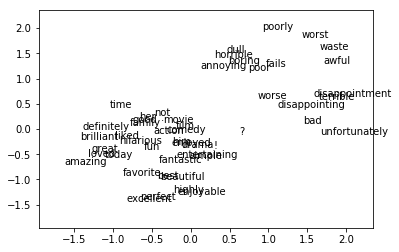

In [12]:
import numpy as np
import matplotlib.pyplot as plt

embedding_matrix = classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights')

for term_index in range(len(informative_terms)):
  # Create a one-hot encoding for our term.  It has 0s everywhere, except for
  # a single 1 in the coordinate that corresponds to that term.
  term_vector = np.zeros(len(informative_terms))
  term_vector[term_index] = 1
  # We'll now project that one-hot vector into the embedding space.
  embedding_xy = np.matmul(term_vector, embedding_matrix)
  plt.text(embedding_xy[0],
           embedding_xy[1],
           informative_terms[term_index])

# Do a little setup to make sure the plot displays nicely.
plt.rcParams["figure.figsize"] = (15, 15)
plt.xlim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.ylim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.show() 

 ## 任务 6：尝试改进模型的效果

看看您能否优化该模型以改进其效果。您可以尝试以下几种做法：

* **更改超参数**或**使用其他优化工具**，比如 Adam（通过遵循这些策略，您的准确率可能只会提高一两个百分点）。
* **向 `informative_terms` 中添加其他术语。**此数据集有一个完整的词汇表文件，其中包含 30716 个术语，您可以在以下位置找到该文件：https://download.mlcc.google.cn/mledu-datasets/sparse-data-embedding/terms.txt 您可以从该词汇表文件中挑选出其他术语，也可以通过 `categorical_column_with_vocabulary_file` 特征列使用整个词汇表文件。

In [13]:
# Download the vocabulary file.
terms_url = 'https://download.mlcc.google.cn/mledu-datasets/sparse-data-embedding/terms.txt'
terms_path = tf.keras.utils.get_file(terms_url.split('/')[-1], terms_url)

262144/253538 [===============================] - 0s 0us/step


In [14]:
# Create a feature column from "terms", using a full vocabulary file.
informative_terms = None
with io.open(terms_path, 'r', encoding='utf8') as f:
  # Convert it to a set first to remove duplicates.
  informative_terms = list(set(f.read().split()))
  
terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key="terms", 
                                                                                 vocabulary_list=informative_terms)

terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[10,10],
  optimizer=my_optimizer
)

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
loss 9.79771
accuracy_baseline 0.5
global_step 1000
recall 0.81224
auc 0.90506387
prediction/mean 0.48596781
precision 0.84117645
label/mean 0.5
average_loss 0.3919084
auc_precision_recall 0.90378726
accuracy 0.82944
---
Test set metrics:
loss 10.368902
accuracy_baseline 0.5
global_step 1000
recall 0.79872
auc 0.8933097
prediction/mean 0.4867514
precision 0.82491946
label/mean 0.5
average_loss 0.4147561
auc_precision_recall 0.8910014
accuracy 0.8146
---


 ## 总结

我们可能获得了比我们原来的线性模型更好且具有嵌入的 DNN 解决方案，但线性模型也相当不错，而且训练速度快得多。线性模型的训练速度之所以更快，是因为它们没有太多要更新的参数或要反向传播的层。

在有些应用中，线性模型的速度可能非常关键，或者从质量的角度来看，线性模型可能完全够用。在其他领域，DNN 提供的额外模型复杂性和能力可能更重要。在定义模型架构时，请记得要充分探讨您的问题，以便知道自己所处的情形。

 ### *可选内容：*在 `embedding_column` 与 `indicator_column` 之间进行权衡

从概念上讲，在训练 `LinearClassifier` 或 `DNNClassifier` 时，需要根据实际情况使用稀疏列。TF 提供了两个选项：`embedding_column` 或 `indicator_column`。

在训练 LinearClassifier（如**任务 1** 中所示）时，系统在后台使用了 `embedding_column`。正如**任务 2** 中所示，在训练 `DNNClassifier` 时，您必须明确选择 `embedding_column` 或 `indicator_column`。本部分通过一个简单的示例讨论了这两者之间的区别，以及如何在二者之间进行权衡。

 假设我们的稀疏数据包含 `"great"`、`"beautiful"` 和 `"excellent"` 这几个值。由于我们在此处使用的词汇表大小为 $V = 50$，因此第一层中的每个单元（神经元）的权重将为 50。我们用 $s$ 表示稀疏输入中的项数。对于此示例稀疏数据，$s = 3$。对于具有 $V$ 个可能值的输入层，带有 $d$ 个单元的隐藏层需要运行一次“矢量 - 矩阵”乘法运算：$(1 \times V) * (V \times d)$。此运算会产生 $O(V * d)$ 的计算成本。请注意，此成本与隐藏层中的权重数成正比，而与 $s$ 无关。

如果输入使用 [`indicator_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/indicator_column) 进行了独热编码（长度为 $V$ 的布尔型矢量，存在用 1 表示，其余则为 0），这表示很多零进行了相乘和相加运算。

 当我们通过使用大小为 $d$ 的 [`embedding_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/embedding_column) 获得完全相同的结果时，我们将仅查询与示例输入中存在的 3 个特征 `"great"`、`"beautiful"` 和 `"excellent"` 相对应的嵌入并将这三个嵌入相加：$(1 \times d) + (1 \times d) + (1 \times d)$。由于不存在的特征的权重在“矢量-矩阵”乘法中与 0 相乘，因此对结果没有任何影响；而存在的特征的权重在“矢量-矩阵”乘法中与 1 相乘。因此，将通过嵌入查询获得的权重相加会获得与“矢量-矩阵”乘法相同的结果。

当使用嵌入时，计算嵌入查询是一个 $O(s * d)$ 计算；从计算方面而言，它比稀疏数据中的 `indicator_column` 的 $O(V * d)$ 更具成本效益，因为 $s$ 远远小于 $V$。（请注意，这些嵌入是临时学习的结果。在任何指定的训练迭代中，都是当前查询的权重。

 正如我们在**任务 3** 中看到的，通过在训练 `DNNClassifier` 过程中使用 `embedding_column`，我们的模型学习了特征的低维度表示法，其中点积定义了一个针对目标任务的相似性指标。在本例中，影评中使用的相似术语（例如 `"great"` 和 `"excellent"`）在嵌入空间中彼此之间距离较近（即具有较大的点积），而相异的术语（例如 `"great"` 和 `"bad"`）在嵌入空间中彼此之间距离较远（即具有较小的点积）。